In [1]:
# 🏠 Building Footprint Flood Exposure Analysis — NC Emergency Management (NCEM)
# Jupyter Notebook Version

"""
This notebook performs:
1. Building footprint loading and cleaning validation
2. FEMA flood zone loading
3. Spatial intersection to identify exposed buildings
4. Summary statistics
5. NCEM-style mapping (basemap + legend + scalebar + north arrow)

Author: Godwin Etim Akpan
Year: 2025
"""


'\nThis notebook performs:\n1. Building footprint loading and cleaning validation\n2. FEMA flood zone loading\n3. Spatial intersection to identify exposed buildings\n4. Summary statistics\n5. NCEM-style mapping (basemap + legend + scalebar + north arrow)\n\nAuthor: Godwin Etim Akpan\nYear: 2025\n'

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Polygon
import pandas as pd
from matplotlib_scalebar.scalebar import ScaleBar


In [3]:
BUILDINGS_PATH = "data_clean/buildings_cleaned.gpkg"
FLOOD_PATH = "hazards/flood_fema_nfhl.gpkg"

OUTPUT_GPKG = "hazards/buildings_in_floodzones.gpkg"
OUTPUT_CSV = "hazards/flood_exposure_summary.csv"
OUTPUT_FIG = "figures/flood_exposure_map_ncem.png"

VALID_FLOOD_ZONES = ["A", "AE", "AH", "AO", "VE", "V"]
TARGET_CRS = "EPSG:3857"


In [4]:
buildings = gpd.read_file(BUILDINGS_PATH)
print("Building sample:")
buildings.head()
print("CRS:", buildings.crs)


Building sample:
CRS: EPSG:3857


In [5]:
flood = gpd.read_file(FLOOD_PATH)

# Keep only relevant flood zones
flood = flood[flood["FLD_ZONE"].isin(VALID_FLOOD_ZONES)]

print(f"Loaded {len(flood)} FEMA flood polygons")


Loaded 3544 FEMA flood polygons


In [6]:
buildings = buildings.to_crs(TARGET_CRS)
flood = flood.to_crs(TARGET_CRS)

print("Reprojected to:", TARGET_CRS)

Reprojected to: EPSG:3857


In [7]:
print("Performing spatial intersection...")

intersected = gpd.overlay(buildings, flood, how="intersection")
intersected["flooded"] = 1

print("Intersected buildings:", len(intersected))


Performing spatial intersection...
Intersected buildings: 1943


In [8]:
buildings["flooded"] = 0  # default

# mark flooded buildings
flooded_ids = intersected.index
buildings.loc[flooded_ids, "flooded"] = 1

total = len(buildings)
flooded = buildings["flooded"].sum()
pct = round((flooded / total) * 100, 3)

print(f"Total buildings: {total}")
print(f"Flooded buildings: {flooded}")
print(f"Percent exposed: {pct}%")


Total buildings: 4672975
Flooded buildings: 1943
Percent exposed: 0.042%


In [9]:
intersected.to_file(OUTPUT_GPKG, driver="GPKG")

pd.DataFrame({
    "total_buildings": [total],
    "flooded_buildings": [flooded],
    "percent_exposed": [pct]
}).to_csv(OUTPUT_CSV, index=False)

print("Saved results to:")
print(" -", OUTPUT_GPKG)
print(" -", OUTPUT_CSV)


Saved results to:
 - hazards/buildings_in_floodzones.gpkg
 - hazards/flood_exposure_summary.csv


C:\Users\profj\AppData\Local\Temp\ipykernel_44788\1094652956.py:28: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\profj\AppData\Local\Temp\ipykernel_44788\1094652956.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


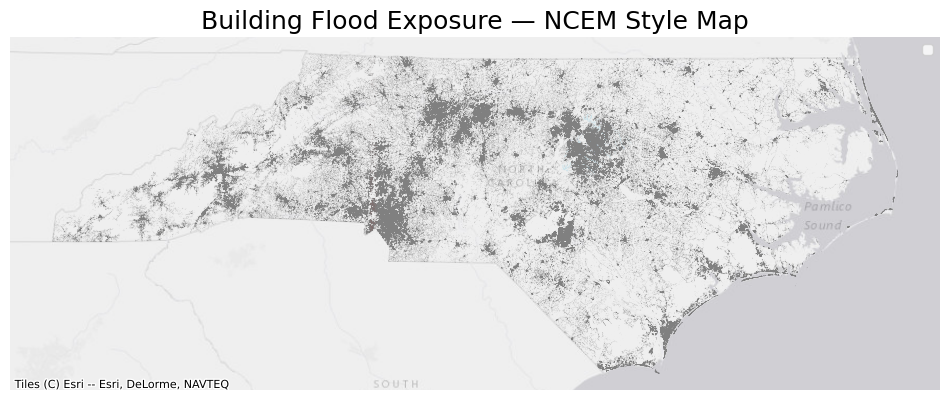

Map saved to: figures/flood_exposure_map_ncem.png


In [10]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot flood polygons
flood.plot(ax=ax, facecolor="lightblue", edgecolor="none", alpha=0.6, label="Flood Zone")

# Plot non-flooded buildings
buildings[buildings["flooded"] == 0].plot(
    ax=ax,
    markersize=1,
    color="gray",
    label="Non-Flooded Buildings"
)

# Plot flooded buildings
buildings[buildings["flooded"] == 1].plot(
    ax=ax,
    markersize=4,
    color="red",
    label="Flooded Buildings"
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas)

ax.set_title("Building Flood Exposure — NCEM Style Map", fontsize=18)
ax.set_axis_off()

plt.legend()

plt.savefig(OUTPUT_FIG, dpi=300, bbox_inches="tight")
plt.show()

print("Map saved to:", OUTPUT_FIG)
